In [ ]:
import os, json, math, glob
from concurrent.futures import ProcessPoolExecutor, as_completed

import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from xml.dom import minidom
import openslide
from openslide.deepzoom import DeepZoomGenerator
from typing import List, Dict, Tuple, Optional

from draw_utils import *

# # DeepZoom 설정 (모델/추론 파이프라인 기본이 224일 가능성 높음)
# TILE_SIZE = 224
# OVERLAP   = 0

In [102]:
annot_list = glob.glob('/home/sjhong/annot_20/*xml')
annot_list

['/home/sjhong/annot_20/ASAP_annotation_DB-000014-F4.xml',
 '/home/sjhong/annot_20/ASAP_annotation_DB-000014-E1.xml',
 '/home/sjhong/annot_20/ASAP_annotation_DB-000604-D4.xml',
 '/home/sjhong/annot_20/ASAP_annotation_DB-000604-I.xml',
 '/home/sjhong/annot_20/ASAP_annotation_DB-000086-F1.xml',
 '/home/sjhong/annot_20/ASAP_annotation_DB-000057-D4.xml',
 '/home/sjhong/annot_20/ASAP_annotation_DB-000122-D1.xml',
 '/home/sjhong/annot_20/ASAP_annotation_DB-000113-C3.xml',
 '/home/sjhong/annot_20/ASAP_annotation_DB-000122-E4.xml',
 '/home/sjhong/annot_20/ASAP_annotation_DB-000681-G.xml',
 '/home/sjhong/annot_20/ASAP_annotation_DB-000037-C1.xml',
 '/home/sjhong/annot_20/ASAP_annotation_DB-000122-F1.xml',
 '/home/sjhong/annot_20/ASAP_annotation_DB-000681-B1.xml',
 '/home/sjhong/annot_20/ASAP_annotation_DB-000113-D5.xml',
 '/home/sjhong/annot_20/ASAP_annotation_DB-000014-H.xml',
 '/home/sjhong/annot_20/ASAP_annotation_DB-000681-F1.xml',
 '/home/sjhong/annot_20/ASAP_annotation_DB-000057-E4.xml',


In [8]:
def parse_annotations(anno_path):
    tree = ET.parse(anno_path)
    root = tree.getroot()

    bboxes = []
    for i, annotation in enumerate(root.findall(".//Annotation")):
        coords = annotation.find("Coordinates")
        xy = []
        for coord in coords.findall("Coordinate"):
            x = float(coord.get("X"))
            y = float(coord.get("Y"))
            xy.append((x, y))
        
        # Rectangle이므로 좌표는 4개
        xs = [p[0] for p in xy]
        ys = [p[1] for p in xy]

        x_min, x_max = min(xs), max(xs)
        y_min, y_max = min(ys), max(ys)

        # 좌측상단, w, h
        x_tl, y_tl = round(x_min), round(y_min)
        w, h = round(x_max - x_min), round(y_max - y_min)

        bboxes.append((x_tl, y_tl, w, h))

    return bboxes

In [127]:
import numpy as np
from matplotlib import cm
# --- jet 컬러매핑 관련 유틸 ---
_JET_SAMPLES = np.array([cm.get_cmap('jet')(i/255.0)[:3] for i in range(256)])  # RGB in [0,1]
_YELLOW_RGB = np.array([1.0, 1.0, 0.0], dtype=float)
_YELLOW_IDX = int(np.argmin((( _JET_SAMPLES - _YELLOW_RGB )**2).sum(axis=1)))  # 노란색 인덱스 근사

def base_to_tile_index(x0, y0, slide, dz, level, tile_size=224, overlap=0, use_bounds=True):
    """base(level-0) 좌표 -> DZ 타일 인덱스(tx,ty)"""
    W0, H0 = slide.dimensions
    Wd, Hd = dz.level_dimensions[level]
    sx, sy = W0 / float(Wd), H0 / float(Hd)
    bx, by, _, _ = get_bounds_offset(slide)
    if not use_bounds:
        bx = by = 0
    dx = (x0 - bx) / sx
    dy = (y0 - by) / sy
    step = tile_size - overlap
    return int(math.floor(dx / step)), int(math.floor(dy / step))

def hex_to_rgb01(hexstr):
    """'#RRGGBB' -> RGB float[0,1]"""
    s = hexstr.lstrip('#')
    r = int(s[0:2],16) / 255.0
    g = int(s[2:4],16) / 255.0
    b = int(s[4:6],16) / 255.0
    return np.array([r,g,b], dtype=float)

def jet_index_of_color(rgb01):
    """주어진 RGB(0~1)가 jet 256단계 중 어디에 가장 가까운지 인덱스 반환"""
    d2 = (( _JET_SAMPLES - rgb01 )**2).sum(axis=1)
    return int(np.argmin(d2))

def is_yellow_or_higher(rgb01):
    """jet에서 노란색(≈peak G,R, B~0) 이상(노랑~빨강)이면 True"""
    idx = jet_index_of_color(rgb01)
    return idx >= _YELLOW_IDX

# --- 메인: ASAP XML에서 '노란색 이상' 타일 좌상단 좌표 추출 ---
def tiles_from_asap_xml_yellow_or_higher(xml_path, slide=None, dz=None, level=None,
                                         tile_size_hint=None, overlap=0,
                                         return_tile_index=False, use_bounds=True):
    """
    return: 리스트(dict)
      - {'x0': base_x, 'y0': base_y, 'tile_size': ts, 'color': '#RRGGBB',
         (선택) 'tx': tx, 'ty': ty}
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()
    out = []

    for ann in root.findall(".//Annotation"):
        color_hex = ann.get('Color', '#000000')
        rgb01 = hex_to_rgb01(color_hex)
        if not is_yellow_or_higher(rgb01):
            continue  # 노란색 미만(파랑/청록/초록)은 스킵

        # 좌표 4개(사각형)에서 좌상단 계산
        coords = ann.find('Coordinates')
        if coords is None: 
            continue
        xs = []
        ys = []
        for c in coords.findall('Coordinate'):
            xs.append(float(c.get('X')))
            ys.append(float(c.get('Y')))
        if not xs or not ys:
            continue

        x0 = int(min(xs))
        y0 = int(min(ys))
        w  = int(round(max(xs) - min(xs)))
        h  = int(round(max(ys) - min(ys)))

        rec = {'x0': x0, 'y0': y0, 'tile_size': 224, 'color': color_hex}

        # 원하면 타일 인덱스도 함께
        if return_tile_index:
            if slide is None or dz is None or level is None:
                raise ValueError("tile 인덱스로 변환하려면 slide, dz, level을 전달하세요.")
            tx, ty = base_to_tile_index(x0, y0, slide, dz, level, tile_size=224, overlap=overlap, use_bounds=use_bounds)
            rec.update({'tx': tx, 'ty': ty})
        out.append(rec)

    return out

/tmp/ipykernel_525466/2291518125.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  _JET_SAMPLES = np.array([cm.get_cmap('jet')(i/255.0)[:3] for i in range(256)])  # RGB in [0,1]


In [106]:
heat_path = glob.glob(f'/home/sjhong/annot_20/*{sample_name}*.xml')[0]
heat_path

'/home/sjhong/annot_20/ASAP_annotation_DB-000122-D1.xml'

In [108]:
tiles = tiles_from_asap_xml_yellow_or_higher(heat_path, tile_size_hint=None)
len(tiles)

70

In [128]:
tiles_idx = tiles_from_asap_xml_yellow_or_higher(
    heat_path, slide=slide, dz=dz, level=16, overlap=0,
    tile_size_hint=None, return_tile_index=True, use_bounds=True
)

In [129]:
len(tiles_idx), tiles_idx[0]

(70,
 {'x0': 88576,
  'y0': 17408,
  'tile_size': 224,
  'color': '#FFAB00',
  'tx': 197,
  'ty': 38})

In [115]:
print(wsi_path)
print(annot_path)

/data/sjhong/wsi/PNU/DB-000122-D1.svs
/home/sjhong/segmentation/histoplus/cell_detection/DB-000122-D1.xml


In [134]:
found_tiles = [
    t for t in data.get("cell_masks", [])
    if (int(t.get("tx", -1)), int(t.get("ty", -1))) in tiles_idx
]
len(found_tiles)

0

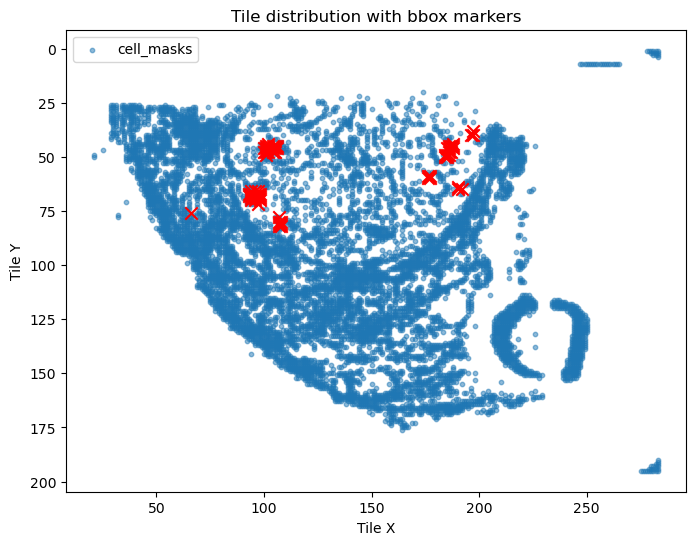

In [133]:
# 기존 플롯에 추가
plt.figure(figsize=(8,6))
plt.scatter(xs, ys, s=10, alpha=0.5, label="cell_masks")
for (tx, ty) in coords:
    plt.scatter(tx, ty, s=80, color="red", marker="x")
plt.legend()
plt.xlabel("Tile X")
plt.ylabel("Tile Y")
plt.title("Tile distribution with bbox markers")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
roi_comment = 'test'
tiles_to_asap_xml(
    wsi_path=wsi_path,
    tiles=tiles_idx,                   # 3k 타일 dict 리스트
    xml_out_path=annot_path,
    color_map=COLOR_MAP,
    roi_comment = roi_comment,
    contained = list(COLOR_MAP.keys()),
    max_workers=45,                 # 코어에 맞게 조정
)

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

In [ ]:
annot_path = annot_list[0]

In [ ]:
lvl = 16

In [40]:
for annot_path in sorted(annot_list[1:]):
    bbox_info_list = parse_annotations(annot_path)
    sample_name = annot_path.split('/')[-1].split('.')[0]
    wsi_path = f"/data/sjhong/wsi/PNU/{sample_name}.svs"
    json_path = f"/home/sjhong/segmentation/histoplus/output/pnu_0924/seg_{sample_name}_588.json"
    with open(json_path, 'r') as f:
        data = json.load(f)
    slide = openslide.OpenSlide(wsi_path)
    dz = DeepZoomGenerator(slide, tile_size=224, overlap=0, limit_bounds=False)

    total_tiles = []

    for x0, y0, w, h in bbox_info_list:
        # (A) 낱개 타일 리스트
        tiles = tiles_covering_base_rect(slide, dz, lvl, x0, y0, w, h,
                                        tile_size=224, overlap=0, return_spans=False)
        if len(tiles) == 1:
            print("I founded this tile:",tiles[0])
            tile = tiles[0]
            
        found_tiles = [
            t for t in data.get("cell_masks", [])
            if (int(t.get("x", -1)), int(t.get("y", -1))) in tiles
        ]
        # print(found_tiles[0])
        total_tiles.extend(found_tiles)


    print(f"총 {len(total_tiles)}개 tile dict 매칭")
    # cell_type = ['Cancer cell', 'Fibroblasts', 'Macrophages', 'Lymphocytes', 'Apoptotic Body', 'Neutrophils']
    roi_comment = f"ROI: x0={x0}, y0={y0}, width={w}, height={h}"
    cell_type = ['a']
    annot_path = f"/home/sjhong/segmentation/histoplus/annotation/ASAP_annotation_{sample_name}_cell_detected.xml"

    tiles_to_asap_xml(
        wsi_path=wsi_path,
        tiles=total_tiles,                   # 3k 타일 dict 리스트
        xml_out_path=annot_path,
        color_map=COLOR_MAP,
        roi_comment = roi_comment,
        contained = list(COLOR_MAP.keys()),
        max_workers=45,                 # 코어에 맞게 조정
)

총 0개 tile dict 매칭
ASAP XML saved: /home/sjhong/segmentation/histoplus/annotation/ASAP_annotation_DB-000014-E1_cell_detected_1.xml
총 3개 tile dict 매칭
ASAP XML saved: /home/sjhong/segmentation/histoplus/annotation/ASAP_annotation_DB-000014-F4_cell_detected_1.xml
총 6개 tile dict 매칭
ASAP XML saved: /home/sjhong/segmentation/histoplus/annotation/ASAP_annotation_DB-000014-H_cell_detected_1.xml
총 102개 tile dict 매칭
ASAP XML saved: /home/sjhong/segmentation/histoplus/annotation/ASAP_annotation_DB-000122-E4_cell_detected_1.xml
총 62개 tile dict 매칭
ASAP XML saved: /home/sjhong/segmentation/histoplus/annotation/ASAP_annotation_DB-000122-F1_cell_detected_1.xml


In [63]:
for annot_path in sorted(annot_list):
    bbox_info_list = parse_annotations(annot_path)
    sample_name = annot_path.split('/')[-1].split('.')[0]
    wsi_path = f"/data/sjhong/wsi/PNU/{sample_name}.svs"
    json_path = f"/home/sjhong/segmentation/histoplus/output/pnu_0924/seg_{sample_name}_588.json"
    with open(json_path, 'r') as f:
        data = json.load(f)
    slide = openslide.OpenSlide(wsi_path)
    dz = DeepZoomGenerator(slide, tile_size=224, overlap=0, limit_bounds=False)

    total_tiles = []

    for x0, y0, w, h in bbox_info_list:
        # (A) 낱개 타일 리스트
        tiles = tiles_covering_base_rect(slide, dz, lvl, x0, y0, w, h,
                                        tile_size=224, overlap=0, return_spans=False)
        if len(tiles) == 1:
            print("I founded this tile:",tiles[0])
            tile = tiles[0]
            
        found_tiles = [
            t for t in data.get("cell_masks", [])
            if (int(t.get("x", -1)), int(t.get("y", -1))) in tiles
        ]
        # print(found_tiles[0])
        total_tiles.extend(found_tiles)


    print(f"총 {len(total_tiles)}개 tile dict 매칭")

총 0개 tile dict 매칭
총 3개 tile dict 매칭
총 6개 tile dict 매칭
총 83개 tile dict 매칭
총 102개 tile dict 매칭
총 62개 tile dict 매칭


In [64]:
[x.split('/')[-1].split('.')[0] for x in sorted(annot_list)]

['DB-000014-E1',
 'DB-000014-F4',
 'DB-000014-H',
 'DB-000122-D1',
 'DB-000122-E4',
 'DB-000122-F1']

In [135]:
annot_path = annot_list[1]
annot_path

'/home/sjhong/annot_20/ASAP_annotation_DB-000014-E1.xml'

In [136]:
bbox_info_list = parse_annotations(annot_path)
bbox_info_list

[(138752, 11776, 512, 512),
 (139264, 11776, 512, 512),
 (140288, 11776, 512, 512),
 (138752, 12288, 512, 512),
 (138752, 12800, 512, 512),
 (139264, 12800, 512, 512),
 (137728, 13312, 512, 512),
 (138240, 13312, 512, 512),
 (140288, 13312, 512, 512),
 (137216, 13824, 512, 512),
 (139776, 13824, 512, 512),
 (137216, 14336, 512, 512),
 (137728, 14336, 512, 512),
 (137216, 14848, 512, 512),
 (137728, 14848, 512, 512),
 (137728, 15360, 512, 512),
 (137728, 15872, 512, 512),
 (138240, 16384, 512, 512),
 (138240, 16896, 512, 512),
 (58368, 12800, 512, 512),
 (58880, 13312, 512, 512),
 (59392, 13312, 512, 512),
 (59392, 13824, 512, 512),
 (59904, 13824, 512, 512),
 (59904, 14336, 512, 512),
 (60416, 14336, 512, 512),
 (61440, 14336, 512, 512),
 (55296, 13312, 512, 512),
 (54784, 13824, 512, 512),
 (55296, 13824, 512, 512),
 (55808, 13824, 512, 512),
 (48640, 14336, 512, 512),
 (49152, 14336, 512, 512),
 (49664, 14336, 512, 512),
 (50176, 14336, 512, 512),
 (54784, 14336, 512, 512),
 (55296, 

In [141]:
sample_name = "DB-000014-F4"
sample_name

'DB-000014-F4'

In [ ]:
# sample_name = annot_path.split('/')[-1].split('.')[0]
wsi_path = f"/data/sjhong/wsi/PNU/{sample_name}.svs"

In [145]:
json_path = f"/home/sjhong/segmentation/histoplus/output/pnu_0924/seg_{sample_name}_588.json"
with open(json_path, 'r') as f:
    data = json.load(f)

In [147]:
json_path

'/home/sjhong/segmentation/histoplus/output/pnu_0924/seg_DB-000014-F4_588.json'

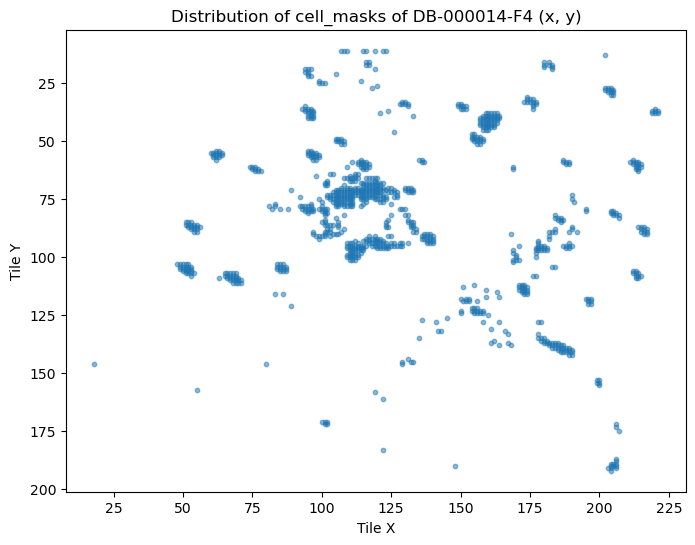

In [146]:
# cell_masks 안의 x, y 꺼내오기
xs = [int(t.get("x", -1)) for t in data.get("cell_masks", [])]
ys = [int(t.get("y", -1)) for t in data.get("cell_masks", [])]

plt.figure(figsize=(8, 6))
plt.scatter(xs, ys, s=10, alpha=0.5)  # s=점 크기, alpha=투명도
plt.xlabel("Tile X")
plt.ylabel("Tile Y")
plt.title(f"Distribution of cell_masks of {sample_name} (x, y)")
plt.gca().invert_yaxis()  # 보통 이미지 좌표계 맞추려면 y축 뒤집는 게 직관적
plt.show()

In [ ]:
slide = openslide.OpenSlide(wsi_path)
dz = DeepZoomGenerator(slide, tile_size=224, overlap=0, limit_bounds=False)

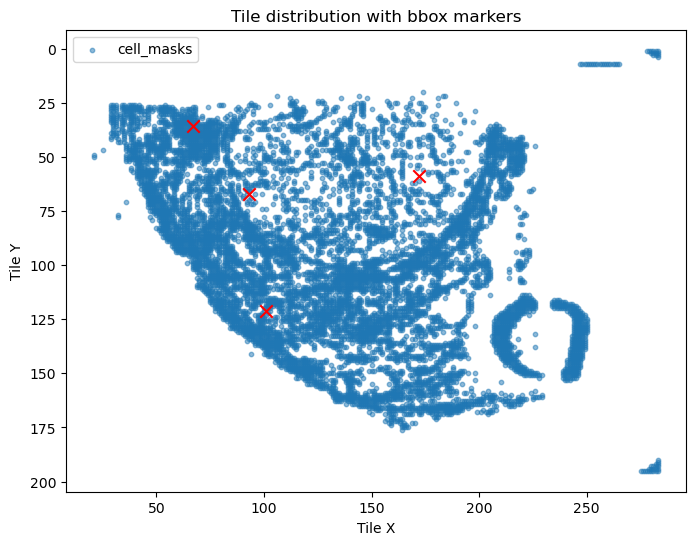

In [ ]:
# base 좌표 -> tile 좌표 변환 함수
def base_to_tile(x0, y0, slide, dz, level, tile_size=224, overlap=0):
    W0, H0 = slide.dimensions
    Wd, Hd = dz.level_dimensions[level]
    sx, sy = W0 / float(Wd), H0 / float(Hd)
    bx, by, _, _ = get_bounds_offset(slide)
    dx = (x0 - bx) / sx
    dy = (y0 - by) / sy
    step = tile_size - overlap
    tx = int(dx // step)
    ty = int(dy // step)
    return tx, ty

# 좌표 변환
coords = [ (x,y) for x,y,_,_ in bbox_info_list]
tile_points = [base_to_tile(x0, y0, slide, dz, level=16) for x0, y0 in coords]

# 기존 플롯에 추가
plt.figure(figsize=(8,6))
plt.scatter(xs, ys, s=10, alpha=0.5, label="cell_masks")
for (tx, ty) in tile_points:
    plt.scatter(tx, ty, s=80, color="red", marker="x")
plt.legend()
plt.xlabel("Tile X")
plt.ylabel("Tile Y")
plt.title("Tile distribution with bbox markers")
plt.gca().invert_yaxis()
plt.show()

In [153]:
annot_list = ['/home/sjhong/segmentation/histoplus/cell_detection/DB-000014-F4.xml',
 '/home/sjhong/segmentation/histoplus/cell_detection/DB-000122-E4.xml',
 '/home/sjhong/segmentation/histoplus/cell_detection/DB-000122-F1.xml']

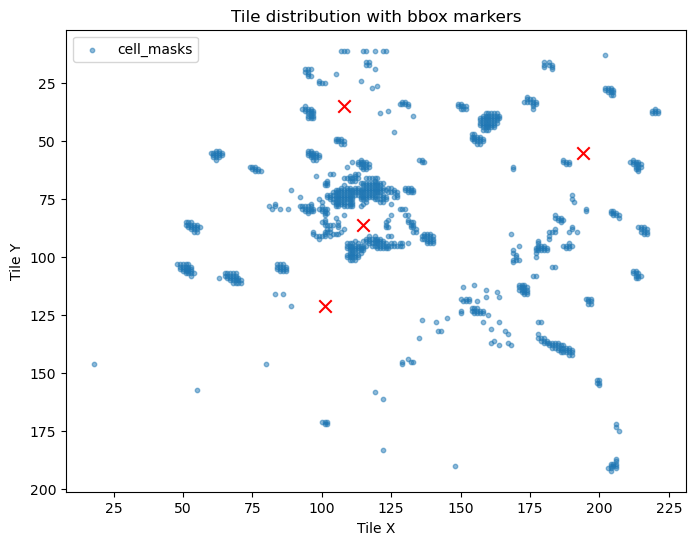

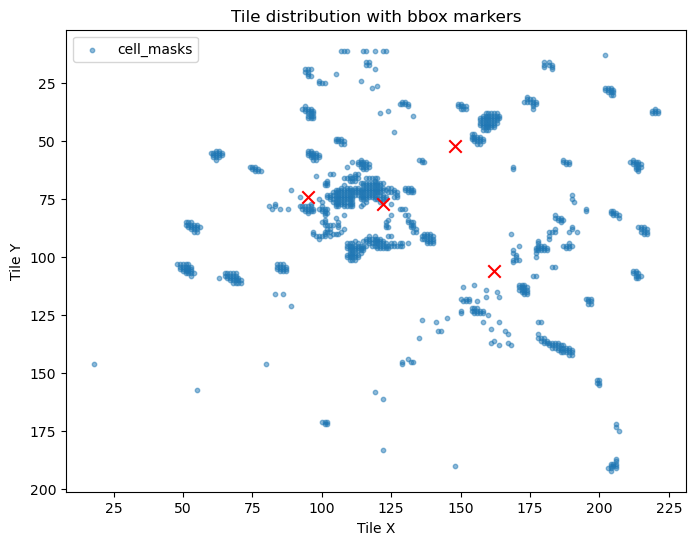

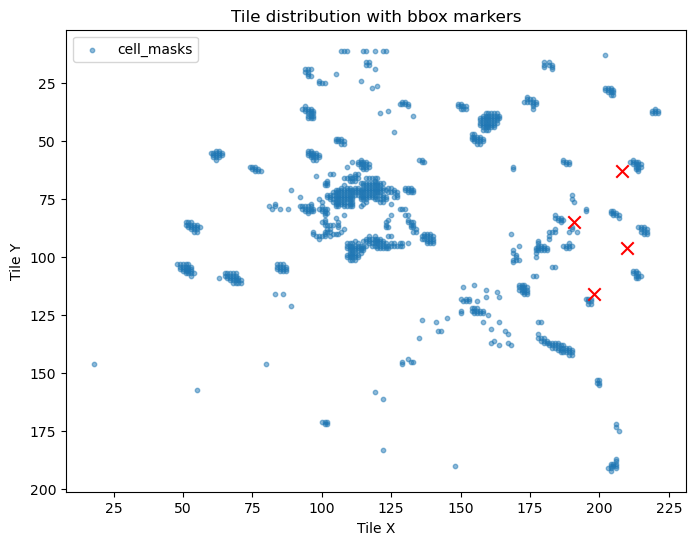

In [ ]:
for annot_path in sorted(annot_list):
    sample_name = annot_path.split('/')[-1].split('.')[0]
    bbox_info_list = parse_annotations(annot_path)
    wsi_path = f"/data/sjhong/wsi/PNU/{sample_name}.svs"
    json_path = f"/home/sjhong/segmentation/histoplus/output/pnu_0924/seg_{sample_name}_588.json"
    with open(json_path, 'r') as f:
        data = json.load(f)
    slide = openslide.OpenSlide(wsi_path)
    dz = DeepZoomGenerator(slide, tile_size=224, overlap=0, limit_bounds=False)
    
    # 좌표 변환
    coords = [(x,y) for x,y,_,_ in bbox_info_list]
    tile_points = [base_to_tile(x0, y0, slide, dz, level=16) for x0, y0 in coords]

    xs = [int(t.get("x", -1)) for t in data.get("cell_masks", [])]
    ys = [int(t.get("y", -1)) for t in data.get("cell_masks", [])]
    
    # 기존 플롯에 추가
    plt.figure(figsize=(8,6))
    plt.scatter(xs, ys, s=10, alpha=0.5, label="cell_masks")
    for (tx, ty) in tile_points:
        plt.scatter(tx, ty, s=80, color="red", marker="x")
    plt.legend()
    plt.xlabel("Tile X")
    plt.ylabel("Tile Y")
    plt.title("Tile distribution with bbox markers")
    plt.gca().invert_yaxis()
    plt.show()

In [98]:
target_tx, target_ty = tile_points[-1]
matched_tiles = [
    t for t in data.get("cell_masks", [])
    if int(t.get("x", -1)) == target_tx and int(t.get("y", -1)) == target_ty
]
len(matched_tiles)

1

In [101]:
len(matched_tiles[0]['masks'])

60